In [1]:
import numpy as np
import pandas as pd
import time
import graphlab as gl
from sklearn.metrics import roc_auc_score
from scipy import stats


import matplotlib.pyplot as plt
%matplotlib inline

This non-commercial license of GraphLab Create for academic use is assigned to tbansal@ucsd.edu and will expire on February 27, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1495518053.log


In [2]:
data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

## changing labels to 1 and -1. 0 is default for no-see on user-item

In [3]:
data.loc[data['is_listened']==0, 'is_listened'] = -1

In [4]:
# listen_type filtering
data = data.loc[data['listen_type']== 1]

In [18]:
# context_type filtering
# data = data.loc[data['context_type']== 1]

## grouping on user-song with mean 'is_listened'. Try others things like latest listen value?

In [5]:
group_data = pd.DataFrame({'target': data.groupby(['user_id', 'media_id'])['is_listened'].mean()}).reset_index()
# group_data = pd.DataFrame({'target': data.groupby(['user_id', 'media_id'])['is_listened'].mean(),\
#                           'user_gender': data.groupby(['user_id', 'media_id'])['user_gender'].mean()}).reset_index()



In [6]:
group_data

,user_id,media_id,target
0,0,211678,1.0
1,0,211796,1.0
2,0,304849,1.0
3,0,311526,1.0
4,0,313635,1.0
5,0,313639,1.0
6,0,314683,1.0
7,0,534628,1.0
8,0,536481,1.0
9,0,536979,1.0


In [111]:
# user information sframe.
user_info = pd.DataFrame({'user_age': data.groupby(['user_id'])['user_age'].mean(),\
                          'user_gender': data.groupby(['user_id'])['user_gender'].mean()}).reset_index()

In [112]:
user_info = gl.SFrame(user_info)

## Convert to Sframe and split. Better split using graphlabs function?

In [7]:
data_sframe = gl.SFrame(group_data)

In [53]:
# Feature engineering

encoder = gl.feature_engineering.create(data_sframe,gl.toolkits.feature_engineering.OneHotEncoder(features = ['context_type']))
transformed_sf = encoder.transform(data_sframe)

In [164]:
data_sframe

user_id,media_id,target,user_age
0,211678,1.0,0.0
0,211796,1.0,0.0
0,304849,1.0,0.0
0,311526,1.0,0.0
0,313635,1.0,0.0
0,313639,1.0,0.0
0,314683,1.0,0.0
0,534628,1.0,0.0
0,536481,1.0,0.0
0,536979,1.0,0.0


In [8]:
train_data, valid_data = gl.recommender.util.random_split_by_user(data_sframe, item_id='media_id', max_num_users=10000)

In [171]:
m = gl.ranking_factorization_recommender.create(train_data, user_id='user_id', \
                                                item_id='media_id', target='target', \
                                                binary_target=False, linear_regularization=0.0000001, \
                                                regularization=0.00001, num_factors=32, ranking_regularization=0,\
                                                num_sampled_negative_examples=4, max_iterations=25)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 1393855 observations with 15825 users and 140409 items.

Data prepared in: 1.71034s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-05    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 5e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 174231 / 1393855 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.28611           | Not Viable                               |

| 1       | 1.32153           | Not Viable                               |

| 2       | 0.330382          | 0.565511                                 |

| 3       | 0.165191          | 0.46425                                  |

| 4       | 0.0825955         | 0.418343                                 |

| 5       | 0.0412978         | 0.436412                                 |

| 6       | 0.0206489         | 0.537188                                 |

| 7       | 0.0103244         | 0.649528                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0825955         | 0.418343                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 133us        | 0.90302           | 0.950274              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1.55s        | 0.816439          | 0.774204              | 0.0825955   |

| 2       | 3.35s        | 0.631467          | 0.717309              | 0.0825955   |

| 3       | 5.16s        | 0.602353          | 0.706654              | 0.0825955   |

| 4       | 6.08s        | 0.590735          | 0.698969              | 0.0825955   |

| 5       | 6.85s        | 0.583885          | 0.692077              | 0.0825955   |

| 6       | 7.66s        | 0.580687          | 0.686458              | 0.0825955   |

| 7       | 8.45s        | 0.576471          | 0.680383              | 0.0825955   |

| 8       | 9.37s        | 0.572696          | 0.674553              | 0.0825955   |

| 9       | 10.27s       | 0.570791          | 0.669685              | 0.0825955   |

| 10      | 11.47s       | 0.568863          | 0.664862              | 0.0825955   |

| 11      | 12.95s       | 0.566592          | 0.660039              | 0.0825955   |

| 12      | 14.77s       | 0.565647          | 0.65622               | 0.0825955   |

| 13      | 16.08s       | 0.564534          | 0.652127              | 0.0825955   |

| 14      | 17.52s       | 0.563082          | 0.648321              | 0.0825955   |

| 15      | 18.83s       | 0.562078          | 0.644756              | 0.0825955   |

| 16      | 20.21s       | 0.561006          | 0.641421              | 0.0825955   |

| 17      | 21.75s       | 0.560161          | 0.638238              | 0.0825955   |

| 18      | 23.16s       | 0.559577          | 0.635284              | 0.0825955   |

| 19      | 24.74s       | 0.558892          | 0.632365              | 0.0825955   |

| 20      | 26.25s       | 0.558453          | 0.629808              | 0.0825955   |

| 21      | 28.08s       | 0.55806           | 0.62727               | 0.0825955   |

| 22      | 29.82s       | 0.557633          | 0.624887              | 0.0825955   |

| 23      | 31.53s       | 0.557194          | 0.622468              | 0.0825955   |

| 24      | 33.09s       | 0.557135          | 0.620409              | 0.0825955   |

| 25      | 34.60s       | 0.556796          | 0.618314              | 0.0825955   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.585799

Final training RMSE: 0.641339

## Compute ROC score

In [172]:
val_pred = m.predict(valid_data)

valid_df = valid_data.to_dataframe()
valid_df.loc[valid_df['target'] >= 0, 'target']  = 1
valid_df.loc[valid_df['target'] < 0, 'target'] = 0

score = roc_auc_score(list(valid_df['target']), val_pred)
print score

0.838808308061


# Prediction and submission file

In [191]:
m = gl.ranking_factorization_recommender.create(data_sframe, user_id='user_id', \
                                                item_id='media_id', target='target', \
                                                binary_target=False, linear_regularization=0.00001, \
                                                regularization=0.00001, num_factors=50, ranking_regularization=0,\
                                                num_sampled_negative_examples=4, max_iterations=100)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 1592963 observations with 15971 users and 151720 items.

Data prepared in: 2.3193s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 50       |

| regularization                 | L2 Regularization on Factors                     | 1e-05    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-05    |

| max_iterations                 | Maximum Number of Iterations                     | 100      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 199120 / 1592963 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 4.62541           | Not Viable                               |

| 1       | 1.15635           | Not Viable                               |

| 2       | 0.289088          | 0.574663                                 |

| 3       | 0.144544          | 0.520135                                 |

| 4       | 0.072272          | 0.457341                                 |

| 5       | 0.036136          | 0.459783                                 |

| 6       | 0.018068          | 0.574195                                 |

| 7       | 0.009034          | 0.667825                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.072272          | 0.457341                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 109us        | 0.903086          | 0.950308              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1.46s        | 0.972081          | 0.907352              | 0.072272    |

| 2       | 2.66s        | 0.710512          | 0.769607              | 0.072272    |

| 3       | 3.98s        | 0.731703          | 0.795781              | 0.072272    |

| 4       | 5.20s        | 0.742618          | 0.793057              | 0.072272    |

| 5       | 6.53s        | 0.689738          | 0.756637              | 0.072272    |

| 6       | 7.73s        | 0.635758          | 0.714687              | 0.072272    |

| 7       | 9.07s        | 0.614198          | 0.695017              | 0.072272    |

| 8       | 10.34s       | 0.597185          | 0.67816               | 0.072272    |

| 9       | 11.48s       | 0.631571          | 0.698988              | 0.072272    |

| 10      | 12.92s       | 0.696175          | 0.747978              | 0.072272    |

| 11      | 14.11s       | 0.683806          | 0.738133              | 0.072272    |

| 12      | 15.29s       | 0.678904          | 0.732959              | 0.072272    |

| 13      | 16.44s       | 0.651021          | 0.712551              | 0.072272    |

| 14      | 17.80s       | 0.630315          | 0.69675               | 0.072272    |

| 15      | 19.04s       | 0.616334          | 0.685604              | 0.072272    |

| 16      | 20.26s       | 0.603796          | 0.675392              | 0.072272    |

| 17      | 21.42s       | 0.594487          | 0.66753               | 0.072272    |

| 18      | 22.73s       | 0.585046          | 0.659547              | 0.072272    |

| 19      | 23.97s       | 0.576927          | 0.651994              | 0.072272    |

| 20      | 25.12s       | 0.619956          | 0.681832              | 0.072272    |

| 21      | 26.36s       | 0.688094          | 0.732454              | 0.072272    |

| 22      | 27.75s       | 0.681054          | 0.727706              | 0.072272    |

| 23      | 29.02s       | 0.680571          | 0.726003              | 0.072272    |

| 24      | 30.40s       | 0.665717          | 0.71526               | 0.072272    |

| 25      | 32.07s       | 0.643758          | 0.699433              | 0.072272    |

| 26      | 33.50s       | 0.62821           | 0.687963              | 0.072272    |

| 27      | 35.26s       | 0.617181          | 0.67968               | 0.072272    |

| 28      | 36.42s       | 0.609602          | 0.673878              | 0.072272    |

| 29      | 37.79s       | 0.603835          | 0.669469              | 0.072272    |

| 30      | 39.04s       | 0.59686           | 0.664182              | 0.072272    |

| 31      | 40.72s       | 0.590633          | 0.659353              | 0.072272    |

| 32      | 42.82s       | 0.58439           | 0.654515              | 0.072272    |

| 33      | 45.12s       | 0.576945          | 0.648623              | 0.072272    |

| 34      | 46.99s       | 0.569734          | 0.642709              | 0.072272    |

| 35      | 49.71s       | 0.580023          | 0.649227              | 0.072272    |

| 36      | 51.85s       | 0.705047          | 0.7398                | 0.072272    |

| 37      | 53.64s       | 0.688205          | 0.728789              | 0.072272    |

| 38      | 55.89s       | 0.699695          | 0.735179              | 0.072272    |

| 39      | 57.23s       | 0.698552          | 0.733959              | 0.072272    |

| 40      | 58.51s       | 0.670742          | 0.714694              | 0.072272    |

| 41      | 59.67s       | 0.651189          | 0.700911              | 0.072272    |

| 42      | 1m 0s        | 0.636755          | 0.690531              | 0.072272    |

| 43      | 1m 2s        | 0.629552          | 0.685369              | 0.072272    |

| 44      | 1m 3s        | 0.62228           | 0.680095              | 0.072272    |

| 45      | 1m 5s        | 0.616751          | 0.676081              | 0.072272    |

| 46      | 1m 7s        | 0.615633          | 0.675352              | 0.072272    |

| 47      | 1m 8s        | 0.613014          | 0.67349               | 0.072272    |

| 48      | 1m 10s       | 0.609481          | 0.670977              | 0.072272    |

| 49      | 1m 12s       | 0.607991          | 0.669986              | 0.072272    |

| 50      | 1m 14s       | 0.605789          | 0.668518              | 0.072272    |

| 51      | 1m 16s       | 0.604665          | 0.667801              | 0.072272    |

| 52      | 1m 17s       | 0.603158          | 0.666837              | 0.072272    |

| 53      | 1m 19s       | 0.599653          | 0.664337              | 0.072272    |

| 54      | 1m 21s       | 0.598033          | 0.663306              | 0.072272    |

| 55      | 1m 23s       | 0.596717          | 0.662456              | 0.072272    |

| 56      | 1m 25s       | 0.59563           | 0.661826              | 0.072272    |

| 57      | 1m 27s       | 0.5915            | 0.65885               | 0.072272    |

| 58      | 1m 28s       | 0.588687          | 0.656906              | 0.072272    |

| 59      | 1m 29s       | 0.586098          | 0.655108              | 0.072272    |

| 60      | 1m 31s       | 0.583172          | 0.653036              | 0.072272    |

| 61      | 1m 32s       | 0.57864           | 0.649722              | 0.072272    |

| 62      | 1m 34s       | 0.574784          | 0.646928              | 0.072272    |

| 63      | 1m 35s       | 0.568983          | 0.642622              | 0.072272    |

| 64      | 1m 37s       | 0.563757          | 0.638672              | 0.072272    |

| 65      | 1m 38s       | 0.557994          | 0.634187              | 0.072272    |

| 66      | 1m 39s       | 0.568052          | 0.641796              | 0.072272    |

| 67      | 1m 41s       | 0.723684          | 0.75325               | 0.072272    |

| 68      | 1m 42s       | 0.704129          | 0.740436              | 0.072272    |

| 69      | 1m 44s       | 0.701872          | 0.73779               | 0.072272    |

| 70      | 1m 45s       | 0.700969          | 0.736094              | 0.072272    |

| 71      | 1m 46s       | 0.687487          | 0.726638              | 0.072272    |

| 72      | 1m 48s       | 0.668531          | 0.713557              | 0.072272    |

| 73      | 1m 49s       | 0.649089          | 0.699928              | 0.072272    |

| 74      | 1m 50s       | 0.637264          | 0.691551              | 0.072272    |

| 75      | 1m 51s       | 0.626482          | 0.683816              | 0.072272    |

| 76      | 1m 53s       | 0.618947          | 0.6784                | 0.072272    |

| 77      | 1m 54s       | 0.613876          | 0.674734              | 0.072272    |

| 78      | 1m 55s       | 0.610263          | 0.672158              | 0.072272    |

| 79      | 1m 56s       | 0.605114          | 0.668422              | 0.072272    |

| 80      | 1m 58s       | 0.602262          | 0.6664                | 0.072272    |

| 81      | 1m 59s       | 0.599766          | 0.664648              | 0.072272    |

| 82      | 2m 0s        | 0.597224          | 0.662874              | 0.072272    |

| 83      | 2m 1s        | 0.59491           | 0.661234              | 0.072272    |

| 84      | 2m 3s        | 0.593292          | 0.660185              | 0.072272    |

| 85      | 2m 4s        | 0.590047          | 0.657898              | 0.072272    |

| 86      | 2m 5s        | 0.587146          | 0.655855              | 0.072272    |

| 87      | 2m 6s        | 0.584657          | 0.654088              | 0.072272    |

| 88      | 2m 8s        | 0.581538          | 0.651883              | 0.072272    |

| 89      | 2m 9s        | 0.579947          | 0.65079               | 0.072272    |

| 90      | 2m 10s       | 0.575783          | 0.647777              | 0.072272    |

| 91      | 2m 12s       | 0.573137          | 0.645914              | 0.072272    |

| 92      | 2m 14s       | 0.570121          | 0.643755              | 0.072272    |

| 93      | 2m 16s       | 0.566198          | 0.640878              | 0.072272    |

| 94      | 2m 18s       | 0.562525          | 0.638165              | 0.072272    |

| 95      | 2m 20s       | 0.558027          | 0.634792              | 0.072272    |

| 96      | 2m 21s       | 0.553559          | 0.631367              | 0.072272    |

| 97      | 2m 22s       | 0.549622          | 0.628311              | 0.072272    |

| 98      | 2m 23s       | 0.562377          | 0.638254              | 0.072272    |

| 99      | 2m 25s       | 0.736753          | 0.762581              | 0.072272    |

| 100     | 2m 27s       | 0.680588          | 0.7249                | 0.072272    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.641289

Final training RMSE: 0.697267

In [192]:
test_data_sframe = gl.SFrame.read_csv('data/test.csv')

Finished parsing file /Users/tushar/Desktop/Data Science Game/data/test.csv

Parsing completed. Parsed 100 lines in 0.098038 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,int,int,int,int,int,int,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/tushar/Desktop/Data Science Game/data/test.csv

Parsing completed. Parsed 19918 lines in 0.157069 secs.

In [193]:
pred = m.predict(test_data_sframe)

In [194]:
submission_file_name = "deezer_predict_" + time.strftime("%Y%m%d_%H%M%S") + ".csv"
test_data['is_listened'] = pred

to_push = ["sample_id", "is_listened"]
test_data[to_push].to_csv(submission_file_name, index=False)

## Results on validation

In [ ]:
# 0.576197031625 for 10^-8
# 0.713714426378 for 10^-8 and modifying the input matrix
# 0.663766337849 for 10^-6 and modifying the input matrix
# 0.714364968875 for 10^-7 and modifying the input matrix
# 0.701378049512 for 10^-7 and modifying the input matrix and 10 latent factors
# 0.704926824027 for 10^-7 and modifying the input matrix and 60 latent factors: RMSE is less.
# 0.707957981743 for 10^-7 and modifying the input matrix and 60 latent factors: RMSE is less.
# 0.663387281063 for 10^-7 and modifying the input matrix and 25 latent factors.
# 0.651746652396 for 10^-7 and modifying the input matrix and neg_sampls = 6
# 0.714348039988 for 10^-7 and reg = 10-8 modifying the input matrix.
# 0.750114088083 for 10^-6 and reg = 10-8 modifying the input matrix.
# 0.778038465954 for 10^-5 and reg = 10-8 modifying the input matrix.
# 0.792415769025 for 10^-5 and reg = 10-5 modifying the input matrix.
# 0.79231144059 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=50.
# 0.791978838071 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=40.
# 0.792187575802 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=80.
# 0.792163807012 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=100.
# 0.792215850001 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=20.
# 0.79227342532 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=15.
# 0.824881834992 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=15, ranking_regularization=0.
# 0.818495085215 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=15, ranking_regularization=0.1.
# 0.750087546363 for 10^-5 and reg = 10^-5 modifying the input matrix, latent factors=15, ranking_regularization=0.5.
# 0.825061387873 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0.
# 0.815397112278 for 10^-5 and reg = 10^-4 modifying the input matrix, ranking_regularization=0.
# 0.824878198452 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0 and num_sampled_ne_exm=6.
# 0.825013429366 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0 and num_sampled_ne_exm=9.
# 0.824995166848 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0 and num_sampled_ne_exm=15.
# 0.824992010313 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0 and num_sampled_ne_exm=15.
# 0.818962581465 for 10^-7 and reg = 10^-9 modifying the input matrix, ranking_regularization=0.
# 0.841567184649 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0, listen_type=1.
# 0.841681974138 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0, listen_type=1 and num_factors=40.
# 0.841715060603 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0, listen_type=1 and num_factors=50.
# 0.842069126545 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0, listen_type=1 and num_factors=70.
# 0.84232855216 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0, listen_type=1 and num_factors=100.
# 0.810082619687 for 10^-5 and reg = 10^-5 modifying the input matrix, ranking_regularization=0, listen_type=1, c_t=1 and num_factors=32.


# 0.833945748416 

# Best-> 50 lf and 100 iter.

#0.842997137215



# Collaborative Filtering

In [ ]:
m = gl.item_similarity_recommender.create(data_sframe, user_id='user_id', item_id='media_id', target='target')

Recsys training: model = item_similarity

Preparing data set.

Data has 1592963 observations with 15971 users and 151720 items.

Data prepared in: 1.92329s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 11.249ms                       | 6.25       |

| 86.348ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 519 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 73.842ms                           | 0          |

| 582.128ms                          | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.19s                               | 0                | 0               |

| 2.19s                               | 0                | 104             |

| 3.19s                               | 0                | 239             |

| 4.19s                               | 0                | 374             |

| 5.20s                               | 0.25             | 419             |

| 6.19s                               | 0.25             | 458             |

+-------------------------------------+------------------+-----------------+

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 7.82s                               | 0.25             | 730             |

| 8.19s                               | 2.5              | 4144            |

| 9.19s                               | 7                | 10666           |

| 10.24s                              | 12               | 18513           |

| 11.44s                              | 13.25            | 20476           |

| 12.20s                              | 14               | 21567           |

| 13.19s                              | 19.25            | 29580           |

| 14.21s                              | 26.5             | 40581           |

| 15.19s                              | 28.25            | 42918           |

| 16.21s                              | 29.25            | 44395           |

| 17.20s                              | 30               | 45678           |

| 18.23s                              | 30.5             | 46549           |

| 19.20s                              | 31.5             | 47906           |

| 20.20s                              | 32.75            | 49692           |

| 21.20s                              | 36.5             | 55452           |

| 22.26s                              | 37.75            | 57497           |

| 23.21s                              | 39.25            | 59727           |

| 24.20s                              | 41               | 62300           |

| 25.20s                              | 43               | 65422           |

| 26.20s                              | 45               | 68343           |

| 27.23s                              | 48.5             | 73710           |

| 28.20s                              | 56               | 85281           |

| 29.20s                              | 62.75            | 95472           |

| 30.20s                              | 66.5             | 100925          |

| 31.20s                              | 68               | 103473          |

| 32.25s                              | 69.5             | 105768          |

| 33.22s                              | 70.25            | 106741          |

| 34.23s                              | 70.75            | 107660          |

| 35.22s                              | 71.5             | 108646          |

| 36.21s                              | 72               | 109527          |

| 37.23s                              | 72.75            | 110436          |

| 38.29s                              | 73.25            | 111460          |

| 39.21s                              | 73.5             | 111875          |

| 40.21s                              | 74               | 112293          |

| 41.26s                              | 74.25            | 112861          |

| 42.24s                              | 74.5             | 113078          |

| 43.41s                              | 74.75            | 113621          |

| 44.26s                              | 75               | 114129          |

| 45.21s                              | 75.25            | 114466          |

| 46.23s                              | 75.75            | 115063          |

| 47.25s                              | 75.75            | 115303          |

| 48.22s                              | 76               | 115654          |

| 49.21s                              | 76.25            | 115901          |

| 50.30s                              | 76.5             | 116165          |

| 51.23s                              | 76.5             | 116404          |

| 52.48s                              | 76.75            | 116581          |

| 53.29s                              | 77               | 116847          |

| 54.66s                              | 77               | 117179          |

| 55.37s                              | 77.25            | 117289          |

| 56.25s                              | 77.25            | 117371          |

| 57.31s                              | 77.25            | 117550          |

| 58.28s                              | 77.5             | 117727          |

| 59.20s                              | 77.5             | 117946          |

| 1m 0s                               | 77.75            | 118285          |

| 1m 1s                               | 78               | 118440          |

| 1m 2s                               | 78               | 118606          |

| 1m 3s                               | 78.25            | 119015          |

| 1m 4s                               | 78.5             | 119312          |

| 1m 5s                               | 78.75            | 119498          |

| 1m 6s                               | 79               | 119880          |

| 1m 7s                               | 79               | 119978          |

| 1m 8s                               | 79               | 120164          |

| 1m 9s                               | 79.25            | 120341          |

| 1m 10s                              | 79.5             | 120673          |

| 1m 11s                              | 79.5             | 120743          |

| 1m 12s                              | 79.75            | 121014          |

| 1m 13s                              | 79.75            | 121199          |

| 1m 14s                              | 80               | 121470          |

| 1m 15s                              | 80               | 121657          |

| 1m 16s                              | 80.25            | 121783          |

| 1m 17s                              | 80.25            | 121848          |

| 1m 18s                              | 80.5             | 122143          |

| 1m 19s                              | 80.5             | 122352          |

| 1m 20s                              | 80.75            | 122552          |

| 1m 21s                              | 80.75            | 122712          |

| 1m 22s                              | 81               | 123211          |

| 1m 23s                              | 81.25            | 123436          |

| 1m 24s                              | 81.25            | 123543          |

| 1m 25s                              | 81.5             | 123777          |

| 1m 26s                              | 81.5             | 123929          |

| 1m 27s                              | 81.5             | 123995          |

| 1m 28s                              | 81.75            | 124158          |

| 1m 29s                              | 81.75            | 124228          |

| 1m 30s                              | 81.75            | 124397          |

| 1m 31s                              | 82               | 124686          |

| 1m 32s                              | 82               | 124749          |

| 1m 33s                              | 82.25            | 125061          |

| 1m 34s                              | 82.25            | 125139          |

| 1m 35s                              | 82.5             | 125239          |

| 1m 36s                              | 82.75            | 125625          |

| 1m 37s                              | 82.75            | 125892          |

| 1m 38s                              | 83               | 126034          |

| 1m 39s                              | 83.25            | 126417          |

| 1m 40s                              | 83.25            | 126672          |

| 1m 41s                              | 83.5             | 126823          |

| 1m 42s                              | 83.5             | 126961          |

| 1m 43s                              | 83.75            | 127209          |

| 1m 44s                              | 83.75            | 127401          |

| 1m 45s                              | 84               | 127494          |

| 1m 46s                              | 84.25            | 128090          |

| 1m 47s                              | 84.25            | 128147          |

| 1m 48s                              | 84.5             | 128303          |

| 1m 49s                              | 84.5             | 128361          |

| 1m 50s                              | 84.75            | 128664          |

| 1m 51s                              | 84.75            | 128747          |

| 1m 52s                              | 85               | 129092          |

| 1m 53s                              | 85               | 129340          |

| 1m 54s                              | 85.25            | 129509          |

| 1m 55s                              | 85.25            | 129613          |

| 1m 56s                              | 85.25            | 129657          |

| 1m 57s                              | 85.5             | 129827          |

| 1m 58s                              | 85.5             | 130052          |

| 1m 59s                              | 85.75            | 130260          |

| 2m 0s                               | 85.75            | 130356          |

| 2m 1s                               | 85.75            | 130422          |

| 2m 2s                               | 86               | 130583          |

| 2m 3s                               | 86               | 130680          |

| 2m 4s                               | 86               | 130853          |

| 2m 5s                               | 86.25            | 131092          |

| 2m 6s                               | 86.25            | 131189          |

| 2m 7s                               | 86.5             | 131373          |

| 2m 8s                               | 86.5             | 131504          |

| 2m 9s                               | 86.75            | 131900          |

| 2m 10s                              | 87               | 132070          |

| 2m 11s                              | 87               | 132275          |

| 2m 12s                              | 87.25            | 132502          |

| 2m 13s                              | 87.5             | 132862          |

| 2m 14s                              | 87.75            | 133285          |

| 2m 15s                              | 87.75            | 133338          |

| 2m 16s                              | 87.75            | 133444          |

| 2m 17s                              | 88.25            | 133963          |

| 2m 18s                              | 88.25            | 134238          |

| 2m 19s                              | 88.5             | 134327          |

| 2m 20s                              | 88.5             | 134487          |

| 2m 21s                              | 88.5             | 134622          |

| 2m 22s                              | 88.75            | 134980          |

| 2m 23s                              | 89               | 135052          |

| 2m 24s                              | 89               | 135213          |

| 2m 25s                              | 89               | 135230          |

| 2m 26s                              | 89               | 135399          |

| 2m 27s                              | 89.25            | 135596          |

| 2m 28s                              | 89.5             | 135960          |

| 2m 29s                              | 89.5             | 136027          |

| 2m 30s                              | 89.5             | 136166          |

| 2m 31s                              | 89.75            | 136185          |

| 2m 32s                              | 89.75            | 136522          |

| 2m 33s                              | 90               | 136624          |

| 2m 34s                              | 90               | 136864          |

| 2m 35s                              | 90.25            | 137014          |

| 2m 36s                              | 90.25            | 137142          |

| 2m 37s                              | 90.5             | 137391          |

| 2m 38s                              | 90.5             | 137509          |

| 2m 39s                              | 90.75            | 137844          |

| 2m 40s                              | 90.75            | 137908          |

| 2m 41s                              | 91               | 138095          |

| 2m 42s                              | 91               | 138421          |

| 2m 43s                              | 91.25            | 138559          |

| 2m 44s                              | 91.25            | 138636          |

| 2m 45s                              | 91.5             | 138831          |

| 2m 46s                              | 91.5             | 138997          |

In [21]:
data.shape

(7558834, 15)

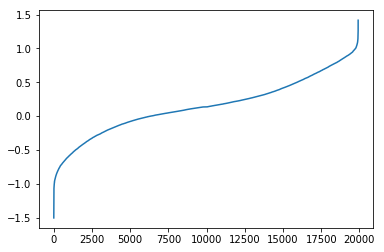

In [120]:
plt.plot(pred.sort())

# Ideas to explore

1. How to deal with multiple is_listen for user-song pair (currently mean) ? - Take latest.
2. Take into account other user/song data? - Try inbuilt parameters in this func.
3. How to leverage the temporal data given esp. for multiple user song pairs.
    - Maybe just take the latest time and target. But good only if test data after train.
4. Context Type
5. If user-song exist use song model, else artist ....

## Artist-User Model

In [103]:
group_artist_data = pd.DataFrame({'target': data.groupby(['user_id', 'artist_id'])['is_listened'].mean()}).reset_index()

In [104]:
data_artist_sframe = gl.SFrame(group_artist_data)

In [78]:
train_data, valid_data = gl.recommender.util.random_split_by_user(data_artist_sframe, item_id='artist_id', max_num_users=10000)

In [90]:
m = gl.ranking_factorization_recommender.create(train_data, user_id='user_id', \
                                                item_id='artist_id', target='target', \
                                                binary_target=False, linear_regularization=0.00001, \
                                                regularization=0.0001, num_factors=32, ranking_regularization=0,\
                                                num_sampled_negative_examples=4)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 932619 observations with 15782 users and 29060 items.

Data prepared in: 1.25934s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-05    |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 116577 / 932619 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.790031          | Not Viable                               |

| 1       | 0.197508          | Not Viable                               |

| 2       | 0.049377          | 0.475306                                 |

| 3       | 0.0246885         | 0.499521                                 |

| 4       | 0.0123442         | 0.532687                                 |

| 5       | 0.00617212        | 0.578233                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.049377          | 0.475306                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 0.854339          | 0.924305              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 427.843ms    | DIVERGED          | DIVERGED              | 0.049377    |

| RESET   | 580.411ms    | 0.854336          | 0.924303              |             |

| 1       | 1.01s        | DIVERGED          | DIVERGED              | 0.0246885   |

| RESET   | 1.19s        | 0.854338          | 0.924304              |             |

| 1       | 1.71s        | 0.589159          | 0.755041              | 0.0123442   |

| 2       | 2.25s        | 0.52726           | 0.710179              | 0.00573818  |

| 3       | 2.85s        | 0.520223          | 0.703887              | 0.00373785  |

| 4       | 3.19s        | 0.517446          | 0.701097              | 0.00277166  |

| 5       | 3.59s        | 0.515966          | 0.699473              | 0.00220237  |

| 6       | 4.09s        | 0.515004          | 0.698356              | 0.00182709  |

| 8       | 4.78s        | 0.513904          | 0.696962              | 0.00136269  |

| 11      | 5.67s        | 0.512999          | 0.695712              | 0.000986555 |

| 13      | 6.26s        | 0.512661          | 0.69518               | 0.000833228 |

| 18      | 7.63s        | 0.512154          | 0.6943                | 0.000600074 |

| 23      | 9.08s        | 0.511879          | 0.693751              | 0.000468874 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.511156

Final training RMSE: 0.693115

In [91]:
val_pred = m.predict(valid_data)

valid_df = valid_data.to_dataframe()
valid_df.loc[valid_df['target'] >= 0, 'target']  = 1
valid_df.loc[valid_df['target'] < 0, 'target'] = 0

score = roc_auc_score(list(valid_df['target']), val_pred)
print score

0.857031858731


In [ ]:
# 0.823140279805 10-5
# 0.857020745772 reg=10-4
# 0.857045216283 latent_Factors=50



In [105]:
m = gl.ranking_factorization_recommender.create(data_artist_sframe, user_id='user_id', \
                                                item_id='artist_id', target='target', \
                                                binary_target=False, linear_regularization=0.00001, \
                                                regularization=0.0001, num_factors=32, ranking_regularization=0,\
                                                num_sampled_negative_examples=4)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 1065699 observations with 15971 users and 30831 items.

Data prepared in: 1.6964s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-05    |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 133212 / 1065699 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.691379          | Not Viable                               |

| 1       | 0.172845          | Not Viable                               |

| 2       | 0.0432112         | 0.482618                                 |

| 3       | 0.0216056         | 0.506106                                 |

| 4       | 0.0108028         | 0.538558                                 |

| 5       | 0.0054014         | 0.583031                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0432112         | 0.482618                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 103us        | 0.854581          | 0.924436              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 891.667ms    | DIVERGED          | DIVERGED              | 0.0432112   |

| RESET   | 1.05s        | 0.854595          | 0.924443              |             |

| 1       | 1.78s        | DIVERGED          | DIVERGED              | 0.0216056   |

| RESET   | 2.00s        | 0.854593          | 0.924442              |             |

| 1       | 2.33s        | 0.587668          | 0.754147              | 0.0108028   |

| 2       | 2.69s        | 0.527219          | 0.710225              | 0.00502163  |

| 3       | 3.13s        | 0.520709          | 0.704318              | 0.00327109  |

| 4       | 3.55s        | 0.518166          | 0.701707              | 0.00242555  |

| 5       | 3.87s        | 0.51678           | 0.700161              | 0.00192735  |

| 6       | 4.19s        | 0.515878          | 0.699109              | 0.00159893  |

| 8       | 4.77s        | 0.514863          | 0.697786              | 0.00119252  |

| 11      | 5.79s        | 0.514078          | 0.696639              | 0.000863358 |

| 13      | 6.38s        | 0.513782          | 0.696143              | 0.000729178 |

| 18      | 7.95s        | 0.513303          | 0.695303              | 0.000525139 |

| 23      | 9.39s        | 0.513071          | 0.694795              | 0.000410323 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.512454

Final training RMSE: 0.694242

In [106]:
test_data_sframe = gl.SFrame.read_csv('data/test.csv')

Finished parsing file /Users/tushar/Desktop/Data Science Game/data/test.csv

Parsing completed. Parsed 100 lines in 0.214693 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,int,int,int,int,int,int,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/tushar/Desktop/Data Science Game/data/test.csv

Parsing completed. Parsed 19918 lines in 0.166972 secs.

In [107]:
pred_artist = m.predict(test_data_sframe)

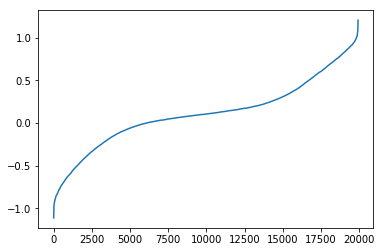

In [117]:
plt.plot(pred_artist.sort())

In [96]:
submission_file_name = "deezer_predict_" + time.strftime("%Y%m%d_%H%M%S") + ".csv"
test_data['is_listened'] = pred_artist

to_push = ["sample_id", "is_listened"]
test_data[to_push].to_csv(submission_file_name, index=False)

## Ensemble

In [118]:
pred_ensemble = pred + pred_artist

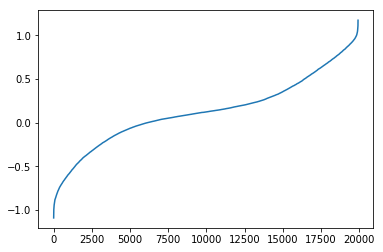

In [119]:
plt.plot(pred_ensemble.sort())

In [125]:
submission_file_name = "deezer_predict_" + time.strftime("%Y%m%d_%H%M%S") + ".csv"
test_data['is_listened'] = pred_ensemble

to_push = ["sample_id", "is_listened"]
test_data[to_push].to_csv(submission_file_name, index=False)

In [ ]:
# try alpha*pred_1 + (1-alpha)*pred_2 and learn alpha.

## Ignore

In [17]:
from sklearn.cross_validation import train_test_split
data = data.loc[:100]
train_data, valid_data, train_labels, valid_labels = train_test_split(data[data.columns.difference(['is_listened'])], data['is_listened'], test_size=0.1)

In [20]:
from scipy.sparse import csr_matrix

users = list(train_data['user_id'])
media = list(train_data['media_id'])
train_labels.loc[train_labels == 0] = -1
listened_data = train_labels.tolist()
sparse_matrix = csr_matrix((listened_data, (users, media)))

In [24]:
sparse_matrix

<10703x900503 sparse matrix of type '<type 'numpy.int64'>'
	with 58 stored elements in Compressed Sparse Row format>

200058

In [13]:
# from scipy.sparse import csr_matrix

# users = list(data['user_id'])
# media = list(data['media_id'])
# data.loc[data['is_listened'] == 0, 'is_listened'] = -1
# listened_data = data['is_listened'].tolist()
# sparse_matrix = csr_matrix((listened_data, (users, media)))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
# check. should be -1
sparse_matrix[9241, 222606]

-1

In [16]:
import implicit

In [17]:
# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=20)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(sparse_matrix)

# recommend items for a user
# recommendations = model.recommend(userid, item_user_data.T)

# find related items
# related = model.similar_items(itemid)

ValueError: Buffer dtype mismatch, expected 'double' but got 'long long'

In [15]:
sparse_matrix

<16548x900503 sparse matrix of type '<type 'numpy.int64'>'
	with 61 stored elements in Compressed Sparse Row format>